# Neural decoding with XGBoost - Demonstration

Use XGBoost to classify task-related variables using neural activity.

The demo script prints to the console the accuracy in decoding the modality of stimuli (auditory or visual) presented to a subject from responses of a single neuron. The configuration file contains details of the specific neuron being shown here, and can be changed to any in the dataset (or in future integrated as part of an online dashboard). Available recording sites are available on [Tableau Public](https://public.tableau.com/app/profile/stephen.town3919/viz/ElectrodeDepths/Dashboard1)

Also returned is a chart with two rows that show (top) the response of the neuron to auditory and visual stimuli as a function of time, and (bottom) the Gini importance values fitted by the model to each time bin. 

We are specifically interested in the ability to identify time periods of neural activity that are particularly informative about stimulus information.

Let's start by loading the relevant modules...

In [1]:
import json
import os
from pathlib import Path
import sys
from typing import List

from dotenv import load_dotenv
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb

from sklearn.preprocessing import LabelEncoder  
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

Now load local modules and environmental settings from the project repository (note that not all modules may be publicly available at the time this demo is published).

In [6]:
load_dotenv()

sys.path.insert(0, str(os.getenv('repo_path')))

from lib import utils
from lib import plot_utils as cplot
from analysis.xgboost import xgboost_preproc as pproc

## 1. Loading and preprocessing

First we need to load configuration, which specifies which neuron we're analysing. This will then give us the parameters we need to query the project database to get specific information about the recording files associated with this neuron and the times of trigger events (stimulus presentations) that will help us find period of activity of interest.

In [17]:
# Load configuration file
with open(Path.cwd() / 'XGBoost_config.json') as fp:
    config = json.load(fp)

# Extend file paths by combining configuration with environment settings
spiketime_filepath = Path(os.getenv("local_home")) / config['spiketime_file']
chanmap_filepath = Path(os.getenv("repo_path")) / config['chan_map']

config['chan'] = utils.electrode_2_channel(config['electrode'], chanmap_filepath)

print(f"Analysing data recorded in F{config['ferret']} {config['region']}")
print(f"\tElectrode {config['electrode']:02d} (chan {config['chan']:02d}) at {config['depth']:.3f} mm")

Analysing data recorded in F1605 APC
	Electrode 01 (chan 04) at -3.900 mm


In [26]:
# Query the database for metadata associated with this 
trigger_df = pproc.get_trial_data(config['ferret'], config['region'], config['electrode'], config['depth'])

# Remove audiovisual trials (these contain no information about modality)
trigger_df = trigger_df[trigger_df.modality != 'Audiovisual'].reset_index(drop=True)

# Print out the metadata columns 
trigger_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 618 entries, 0 to 617
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   start_date       618 non-null    datetime64[ns]
 1   datetime         618 non-null    datetime64[ns]
 2   h5_file          618 non-null    object        
 3   starttime        618 non-null    float64       
 4   mcs_triggertime  609 non-null    float64       
 5   modality         618 non-null    object        
 6   response         618 non-null    object        
dtypes: datetime64[ns](2), float64(2), object(3)
memory usage: 33.9+ KB


Now we need to load spike times that may (or may not) contain information about labels in the metadata (e.g. trigger modality). Spike times for the full project are held in an hdf5 file (not yet published) organized hierarchically by recording file and channel. We therefore request spike times for a specific channel, recorded in one or more files.

In [41]:
spikes = pproc.load_spike_data(
    filepath = spiketime_filepath,
    rec_files = list(td.h5_file.unique()), 
    chan = config['chan'])

# Print how many spikes are recorded in each file
for recording_file, spike_times in spikes.items():

    mean_rate = len(spike_times) / max(spike_times)
    print(f"{recording_file}: {len(spike_times)} spikes, mean rate = {mean_rate:.3f} spikes per second")

2018-01-01T09-45-45McsRecording_2.h5: 29652 spikes, mean rate = 28.433 spikes per second
2018-01-01T15-14-27McsRecording_2.h5: 30910 spikes, mean rate = 22.033 spikes per second
2018-01-02T08-42-39McsRecording_2.h5: 25574 spikes, mean rate = 16.834 spikes per second
2018-01-02T15-06-57McsRecording_2.h5: 81852 spikes, mean rate = 48.044 spikes per second
2018-01-03T08-28-33McsRecording_2.h5: 94184 spikes, mean rate = 40.061 spikes per second
2018-01-03T13-43-47McsRecording_2.h5: 85572 spikes, mean rate = 35.992 spikes per second
2018-01-05T09-56-48McsRecording_2.h5: 83522 spikes, mean rate = 40.608 spikes per second
2018-01-09T15-20-18McsRecording_2.h5: 80644 spikes, mean rate = 47.664 spikes per second
2018-01-29T10-56-31McsRecording.h5: 114437 spikes, mean rate = 35.071 spikes per second
2018-01-29T15-06-31McsRecording.h5: 4606 spikes, mean rate = 17.090 spikes per second
2018-01-31T08-32-10McsRecording.h5: 99504 spikes, mean rate = 41.991 spikes per second
2018-01-31T14-52-25McsRecor

Finally, we count spikes in time bins around the trigger times. This gives us the features for each label, for which we can then build a classifier

(618, 105)


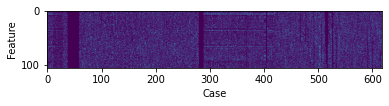

In [45]:
bins = cplot.create_bins((config['bin_start'], config['bin_end']), config['bin_width'])

spike_counts = pproc.bin_spikes(trigger_df, spikes, bins)

print(spike_counts.shape)
# Plot data to see if it makes sense (note that we transpose the plot to fit the notebook, so every column is a case and every row is a feature)
plt.figure()
plt.imshow(spike_counts.T)
plt.xlabel('Case')
plt.ylabel('Feature')
plt.show()

## Setting up classifier

Our goal is to classify the modality of the stimulus presented in each case, as so we'll use the sklearn LabelEncoder to create labels. 

We're going to use K-fold cross-validation, where the number of folds is set in the configuration file.

In terms of performance monitoring, we're interested in overall accuracy. But we're also interested in how each classifier weights time in the decision making process, and to monitor this, we'll record the feature importances for each fold.

In [46]:
# Split the dataset
le = LabelEncoder()
trial_labels = le.fit_transform(trigger_df.modality)

# Run in cross-validation
kf = KFold(n_splits=config['k_folds'], shuffle=True, random_state=35)
kf.get_n_splits(spike_counts)

# Preassign lists for assessing classifiers built on each fold
feature_importances = []

In [51]:
# Use a count to show our progress (as it can take a few seconds for each fold - could add timit to check)
fold_count = 1

# For each fold
for train_idx, test_idx in kf.split(spike_counts):

    print(f"Running fold {fold_count} of {config['k_folds']}")
    fold_count += 1
    
    X_train, X_test = spike_counts[train_idx], spike_counts[test_idx]
    y_train, y_test = trial_labels[train_idx], trial_labels[test_idx]

    xgb_cl = xgb.XGBClassifier(**config['xgb_params'])
    xgb_cl.fit(X_train, y_train)

    ypred = xgb_cl.predict(X_test)
    
    feature_importances.append(
        xgb_cl.feature_importances_
        )

    print(f"\tScore = {accuracy_score(y_test, ypred)*100:.1f}% correct")

Running fold 1 of 8
	Score = 94.9% correct
Running fold 2 of 8
	Score = 96.2% correct
Running fold 3 of 8
	Score = 94.8% correct
Running fold 4 of 8
	Score = 92.2% correct
Running fold 5 of 8
	Score = 100.0% correct
Running fold 6 of 8
	Score = 90.9% correct
Running fold 7 of 8
	Score = 100.0% correct
Running fold 8 of 8
	Score = 97.4% correct


Now lets plot an example of the training data that the classifier is seeing, and compare that to the feature importance scores for each time point

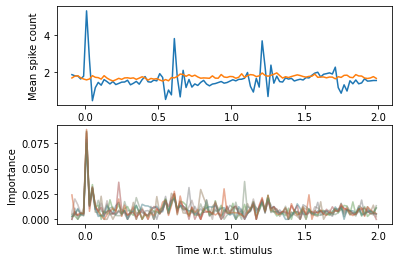

In [52]:
# Compare feature importances to underlying data_
fig, ax = plt.subplots(2,1)

for y in np.unique(y_train):
    ax[0].plot(
        bins['centers'], 
        np.mean(X_train[y_train == y, :], axis=0),
        label=str(y))

ax[0].set_ylabel('Mean spike count')

for fi in feature_importances:
    ax[1].plot(bins['centers'], fi, alpha=0.2)

ax[1].set_xlabel('Time w.r.t. stimulus')
ax[1].set_ylabel('Importance')

plt.show()


Given the difference in response in the two conditions, it's perhaps not surprising that we're reaching very high performance (90-100%) with this classifier. The feature importances confirm that the stimulus onset response of the neuron is the most informative period of activity for making this classification, and the model on each fold always reaches this conclusion.